In [15]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

# Data

The data set which will be used in this notebook is from kaggle. You can visit the following link for it: https://www.kaggle.com/c/nlp-getting-started. In total, there are 10900 tweets in this data set. 

**The features consist of:**


**id**: ID of the tweet (int64).

**keyword**: The keyword of the tweet (String).

**location**: The location of the tweet (String).

**text**: The tweet (String).

**target:** The classification of the tweet as either a disaster or not indicated by a 1 or 0 respectively.



In [3]:
df = pd.read_csv("datasets/nlp-getting-started/train.csv")

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Below is the distribution of the target variable:

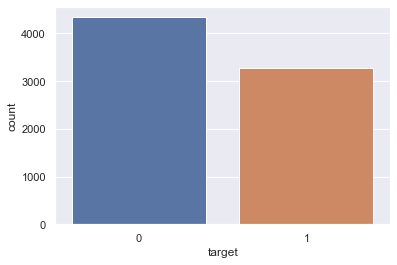

In [8]:
sns.set_theme()
ax = sns.countplot(x="target", data=df)

There seems to not be too much class imbalance. This is certainly much better than other data sets that I have worked with in the past. It would be interesting to see how using SMOTE and other methods used to tackle class imbalance would affect the results when applying BERT.

Next up, we split our data into train and test sets, perform label encoding and tokenize the text.

# Train/Test Split

In [9]:
x = df.text.values
y = df.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

# Label Encoding

In [18]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)
dummy_y_train = to_categorical(encoded_Y_train)

# Tokenization

To tokenize the text, functions from official.nlp.bert package and the pretrained BERT model will be used.


For more information about BERT, please see: https://jalammar.github.io/illustrated-bert/ and https://arxiv.org/abs/1810.04805

In [19]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [20]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Above, we have a couple of variables that have been loaded using the bert_layer which was downloaded:

1 -- vocab_file: reads the vocab file that is associated to the model.

2 -- do_lower_case: This will cause the text to be reformated so that all text will be 
                    in lower case.

3 -- tokenizer: This builds the tokenizer using the two previous variables. 


In [21]:
do_lower_case

False

Finally, we need to add two more tokens: classification and seperation. These two will be added through functions that will tokenize the text.

In [22]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [23]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [57]:
print('Tokenized tweets shape', tweets.shape.as_list())

Tokenized tweets shape [6090, None]


In [25]:
tweets[0]

<tf.Tensor: shape=(23,), dtype=int32, numpy=
array([ 48939,  47173,  10149,  11951,  10529,  10114,  10149,    169,
        11057, 100563,  27244,  10123,  11327,  10105,  28245,  10108,
        14909,  10111,  21180,    119,    119,    119,    102],
      dtype=int32)>

In [26]:
x_train[0]

'Seriously do we have to do a tactical riot against the headquarters of Disney and Marvel...'

Below, you will be able to see how the tokenizer does the tokenizing. 

In [27]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Seri [48939]
##ously [47173]
do [10149]
we [11951]
have [10529]
to [10114]
do [10149]
a [169]
ta [11057]
##ctical [100563]
rio [27244]
##t [10123]
against [11327]
the [10105]
headquarters [28245]
of [10108]
Disney [14909]
and [10111]
Marvel [21180]
. [119]
. [119]
. [119]


Still need to add classification token.

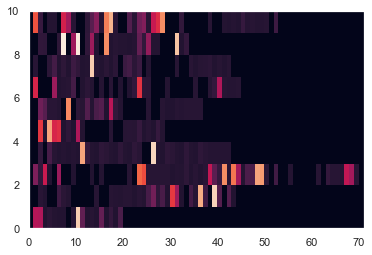

In [28]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

Above is a graphical representation of the tokenized tweets. The first token is the classification token. Other coloured blocks other than the background are other tokens. And the background is padding.

# Mask and Input Type

The model expects two more inputs:

- The input mask

- The input type

The mask allows the model to differentiate between the content and the padding. The mask has the same shape as the input_word_ids. It contains a 1 anywhere the input_word_ids is not padding.

In [69]:
#input_word_ids

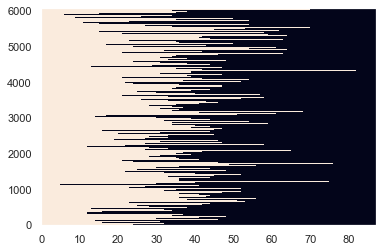

In [30]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Each white block above has some input. We made this for the model to differentiate between padding and input.

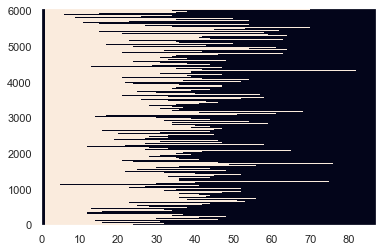

In [31]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

It is rather hard to see but, we added an empty block in front of each tweet for the classification token. See the tensor below:

In [32]:
input_type_ids

<tf.Tensor: shape=(6090, 87), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

# Making Functions For Normal Usage

So at this point we have all of our three inputs:

1 -- Tokens

2 -- Input mask

3 -- Input type

If we can remake everything into functions, it could make our life easier now and in the future.

In [33]:
lens = [len(i) for i in input_word_ids]

In [35]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 87


Let us make the max length larger.

In [36]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 130


The functions themselves:

In [37]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [38]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

# Training

Here we will need to set up our model using the inputs that were made previously along with the BERT model and an output layer based on the number of classes we are using.

In [39]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Our Model:

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Here we are setting up the training parameters:

In [41]:
epochs = 3
batch_size = 16 
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [42]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 130)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 130)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 130)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [44]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
381/381 [==============================] - 2947s 8s/step - loss: 0.5643 - accuracy: 0.7036 - val_loss: 0.4397 - val_accuracy: 0.8063
Epoch 2/3
381/381 [==============================] - 2866s 8s/step - loss: 0.3621 - accuracy: 0.8601 - val_loss: 0.4318 - val_accuracy: 0.8142
Epoch 3/3
381/381 [==============================] - 2818s 7s/step - loss: 0.2660 - accuracy: 0.8979 - val_loss: 0.4772 - val_accuracy: 0.8188


In [45]:
#model.save("BERT_Disaster_Calssification")

INFO:tensorflow:Assets written to: BERT_Disaster_Calssification/assets


INFO:tensorflow:Assets written to: BERT_Disaster_Calssification/assets


In [46]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9307
Testing Accuracy:  0.8188


In [47]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

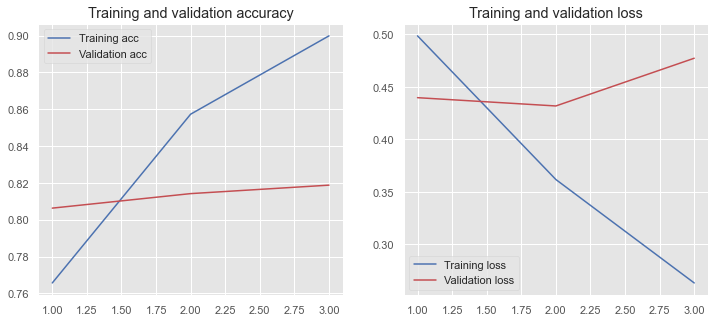

In [48]:
plot_history(history)

From looking at the graph above, the validation loss jumps significantly while the validation accuracy stayed the same more or less at the 2nd epoch. 

The training and validation loss graph indicates over-fitting. The next step for me in this project is to tweak this model to improve validation performance. Nevertheless, I was able to learn about and implement BERT (a fairly new algorithm made in 2018) and increase my validation performance compared to the work I had done with LSTM.



In [49]:
model.save("BERT_Disaster_CalssificationV2")

INFO:tensorflow:Assets written to: BERT_Disaster_CalssificationV2/assets


INFO:tensorflow:Assets written to: BERT_Disaster_CalssificationV2/assets


In [50]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model_fname = 'Disaster_BERT'
my_wd = 'datasets/nlp-getting-started'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: datasets/nlp-getting-started/Disaster_BERT/assets


INFO:tensorflow:Assets written to: datasets/nlp-getting-started/Disaster_BERT/assets


In [52]:
model_fname = 'Disaster_BERT'
my_wd = 'datasets/nlp-getting-started'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [53]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8188


In [54]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 130)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 130)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 130)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [55]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [56]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

Seri [48939]
##ously [47173]
do [10149]
we [11951]
have [10529]
to [10114]
do [10149]
a [169]
ta [11057]
##ctical [100563]
rio [27244]
##t [10123]
against [11327]
the [10105]
headquarters [28245]
of [10108]
Disney [14909]
and [10111]
Marvel [21180]
. [119]
. [119]
. [119]
